In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.models import Model, load_model
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score,confusion_matrix, auc, roc_curve

%cd /content/drive/MyDrive/Steel Defect Detection and Localization
from utilities import rle2mask,mask2rle, DataGenerator, dice_coef,dice_loss, prediction

/content/drive/MyDrive/Steel Defect Detection and Localization


# Configurations

In [ ]:
DIR = '/content/drive/MyDrive/Steel Defect Detection and Localization/'
TRAINING_IMAGES = '/content/drive/MyDrive/Steel Defect Detection and Localization/train_images'
TEST_IMAGES = '/content/drive/MyDrive/Steel Defect Detection and Localization/test_images'

BATCH_SIZE = 24
CLASSIFIER_MODEL_EPOCH = 40
CLASSIFIER_MODEL_PATIENCE = 30
CLASSIFIER_MODEL_IMAGE_SIZE = 299
CLASSIFIER_MODEL_PATH = '/content/drive/MyDrive/Steel Defect Detection and Localization/CLASSIFER_MODEL/classifer_model_xception.hdf5'

SEGMENTATION_MODEL_EPOCH = 20
SEGMENTATION_MODEL_PATIENCE = 15
SEGMENTATION_MODEL_IMAGE_SIZE = 256
SEGMENTATION_MODEL_PATH = '/content/drive/MyDrive/Steel Defect Detection and Localization/SEGMENTATION_MODEL/segmentation_model_resunet_2.hdf5'

# Load Data

In [ ]:
DF_TRAIN = pd.read_csv(DIR+'train.csv')
DF_TRAIN.head(5) 

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [ ]:
# Creating a dataframe of Test Images
test_images = []
for i in os.listdir(TEST_IMAGES):
  if i not in test_images:
    test_images.append(i)

DF_TEST = pd.DataFrame(test_images, columns=['ImageId'])
DF_TEST.to_csv(DIR+'test.csv', index=False)

# Seperate Images with defect from non-defect images

In [ ]:
# Unique images in the dataframe
defect = DF_TRAIN['ImageId'].unique()
# Images from training directory which are not in the DF_TRAIN
defect_images = []
for i in os.listdir(TRAINING_IMAGES):
  if i not in defect_images:
    if i in defect.tolist():
      defect_images.append([i,1])
    else:
      defect_images.append([i,0])

image_id = pd.DataFrame(list(map(lambda x:x[0],defect_images)),columns=['ImageId'])
defect_present = pd.DataFrame(list(map(lambda x:x[1],defect_images)),columns=['defect_present'])
ALL_IMAGES_DF = pd.concat([image_id,defect_present],axis=1)
ALL_IMAGES_DF.head(5)

,ImageId,defect_present
0,e83d27de8.jpg,1
1,ea23dae53.jpg,1
2,e9eb5a464.jpg,0
3,e9c4686f0.jpg,1
4,e8a04b4f8.jpg,1


In [ ]:
# save dataframe
ALL_IMAGES_DF.to_csv('/content/drive/MyDrive/Steel Defect Detection and Localization/all_images_df.csv', index=False)

# EDA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


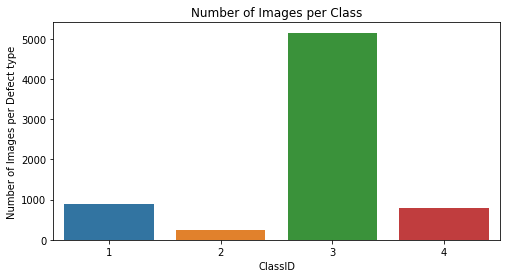

In [ ]:
# Number of datapoints/images per Class
plt.figure(figsize=(8,4))
sns.countplot(DF_TRAIN['ClassId'])
plt.xlabel('ClassID')
plt.ylabel('Number of Images per Defect type')
plt.title('Number of Images per Class')
plt.show()

 **Observation:**

This dataset is **imbalanced** as the number of images with ClassId 3 are much much more than the other ClassId

In [ ]:
DF_EDA = DF_TRAIN.copy()
DF_EDA['defect_present'] = DF_EDA['ClassId'].map(lambda x:1)

In [ ]:
# Some images are classified with more than one defect,

defect_type = DF_EDA.groupby(['ImageId'])['defect_present'].sum()
defect_type.value_counts()

1    6239
2     425
3       2
Name: defect_present, dtype: int64

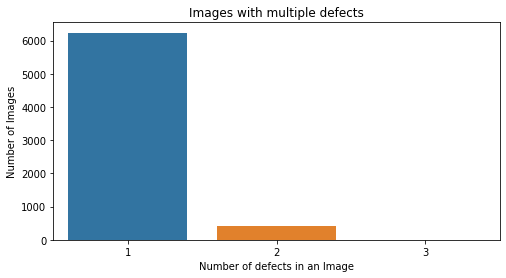

In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts())
plt.xlabel('Number of defects in an Image')
plt.ylabel('Number of Images')
plt.title('Images with multiple defects')
plt.show()

**Observation:**



*    There are only 2 image with 3 types of defects 
*    There are 425 images with 2 types of defects
*    There are 6239 images with 1 type of defect

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


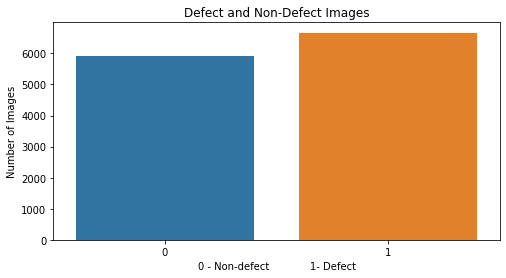

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(ALL_IMAGES_DF['defect_present'])
plt.ylabel('Number of Images')
plt.xlabel('0 - Non-defect             1- Defect')
plt.title('Defect and Non-Defect Images')
plt.show()

In [ ]:
ALL_IMAGES_DF['defect_present'].value_counts()

1    6666
0    5902
Name: defect_present, dtype: int64

## Visualizing the Images

In [ ]:
%cd /content/drive/MyDrive/Steel Defect Detection and Localization
from utilities import rle2mask, mask2rle
train_images_dir = '/content/drive/MyDrive/Steel Defect Detection and Localization/train_images'

/content/drive/MyDrive/Steel Defect Detection and Localization


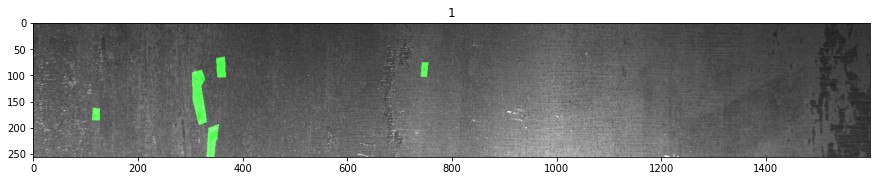

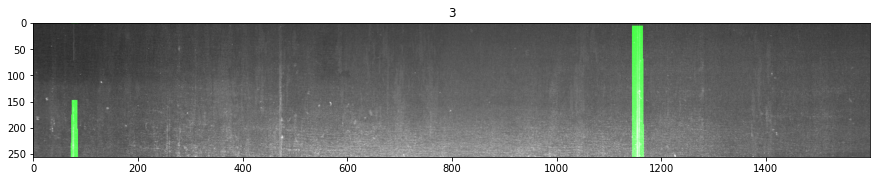

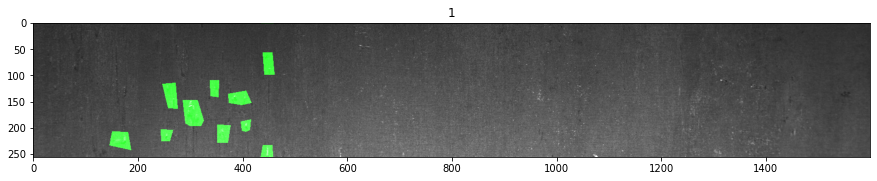

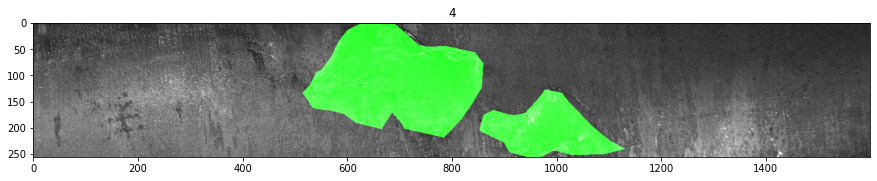

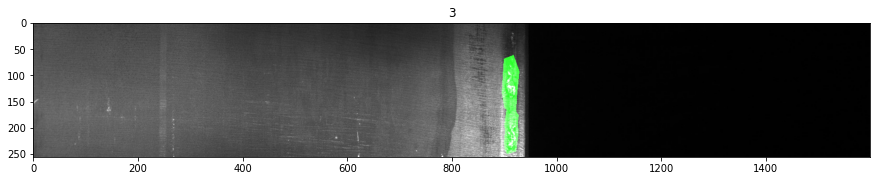

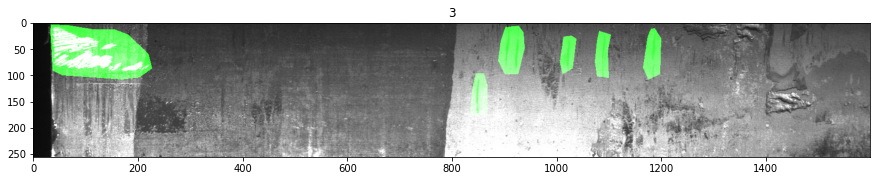

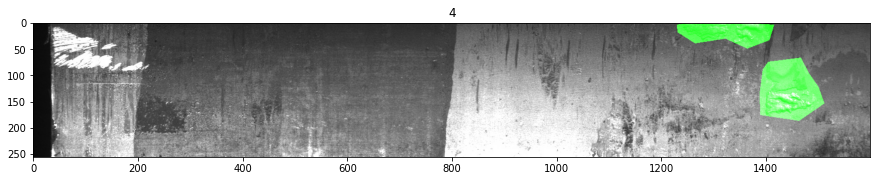

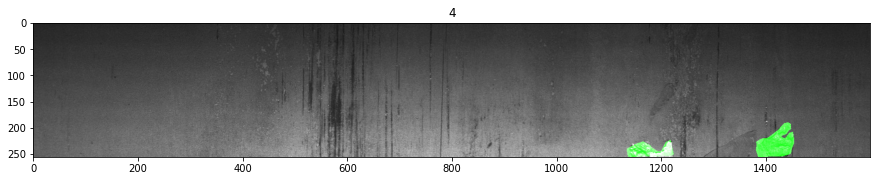

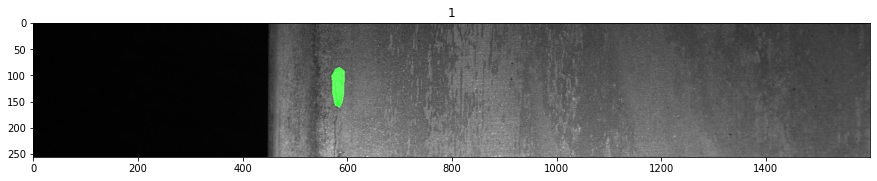

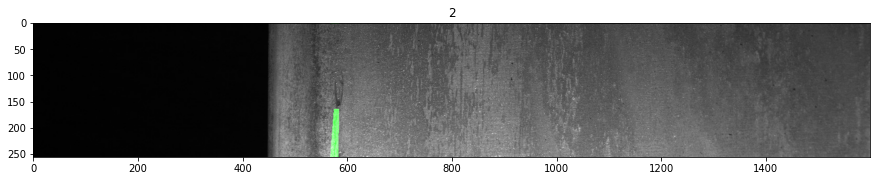

In [ ]:
for i in range(10):
  image = io.imread(os.path.join(train_images_dir, train_df['ImageId'][i]))

  # Convert the images to RGB format using openCV
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # mask on the image using rle2mask
  mask = rle2mask(rle = train_df['EncodedPixels'][i], height= image.shape[0], width= image.shape[1])

  #Color mask pixel with value 1 
  image[mask == 1,1] = 255 # making mask green

  #Show the image
  plt.figure(figsize=(15,5))
  plt.title(train_df['ClassId'][i])
  plt.imshow(image)


In [ ]:
print('The size of image is : ', mask.shape[0],'x',mask.shape[1],'\n')

The size of image is :  256 x 1600 



In [ ]:
def get_rle_sum_plot(df, class_id):
  rle_sum = []
  for i in range(len(df)):
    if df['ClassId'][i]==class_id:
      splitted_rle = df['EncodedPixels'][i].split(' ')[1::2]
      count = 0
      for j in splitted_rle:
        count = count + int(j)
      rle_sum.append(count)
    else:
      rle_sum.append(0)
  column_name = 'rle_sum_'+str(class_id)
  df[column_name] = rle_sum
  temp = df[df[column_name]!=0][column_name]
  plt.figure(figsize=(8,4))
  sns.distplot(temp, fill=True)
  plt.show()

In [ ]:
def get_rle_sum_percentile(df, column_name):
  print('Mean = ' ,df[column_name].mean())
  for i in range(0,100,25):
    temp = df[df[column_name]!=0][column_name]
    sorted = np.sort(temp,axis = None)
    percentile = sorted[int(len(sorted)*(float(i)/100))]
    print("{}th percentile = {}".format(i,percentile))
    percentile_99 = sorted[int(len(sorted)*(float(99)/100))]
  print("99th percentile = ", percentile_99)
  print("100th percentile = ",sorted[-1])
  

In [ ]:
# making a copy of original dataframe
df = train_df.copy()

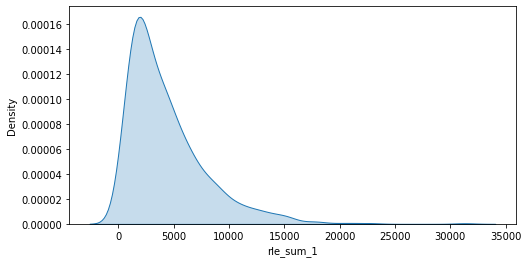

Mean =  551.3923890063425
0th percentile = 163
25th percentile = 1762
50th percentile = 3326
75th percentile = 5795
99th percentile =  15689
100th percentile =  31303


In [ ]:
get_rle_sum_plot(df=df, class_id=1)
get_rle_sum_percentile(df, column_name='rle_sum_1')

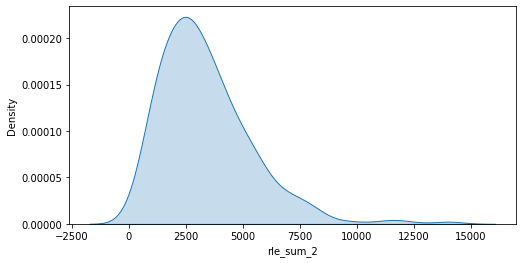

Mean =  117.61395348837209
0th percentile = 316
25th percentile = 1947
50th percentile = 2944
75th percentile = 4439
99th percentile =  11302
100th percentile =  14023


In [ ]:
get_rle_sum_plot(df=df, class_id=2)
get_rle_sum_percentile(df, column_name='rle_sum_2')

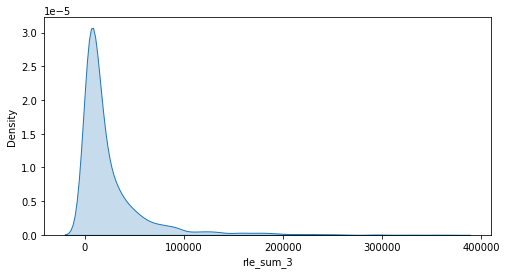

Mean =  18506.96250880902
0th percentile = 115
25th percentile = 5054
50th percentile = 11960
75th percentile = 29034
99th percentile =  193938
100th percentile =  368240


In [ ]:
get_rle_sum_plot(df=df, class_id=3)
get_rle_sum_percentile(df, column_name='rle_sum_3')

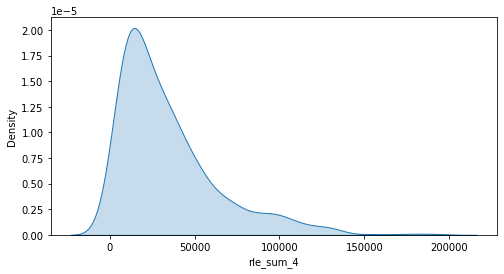

Mean =  3880.7007751937986
0th percentile = 491
25th percentile = 13114
50th percentile = 25357
75th percentile = 45221
99th percentile =  129924
100th percentile =  192780


In [ ]:
get_rle_sum_plot(df=df, class_id=4)
get_rle_sum_percentile(df, column_name='rle_sum_4')

**Observations:**



*    For Defect 1, sum of encoding ranges from 163 to 31303
*    For Defect 2, sum of encoding ranges from 316 to 14023
*    For Defect 3, sum of encoding ranges from 115 to 368240
*    For Defect 4, sum of encoding ranges from 419 to 192780
*    All values have a sudden increase after 99th percentile

**Observation:**



*    For Defect 2, sum of encoding ranges from 316 to 14023

In [ ]:
def get_rle_sum_percentile(df, column_name):
  for i in range(0,100,25):
    temp = df[df[column_name]!=0][column_name]
    sorted = np.sort(temp,axis = None)
    percentile = sorted[int(len(sorted)*(float(i)/100))]
    print("{}th percentile = {}".format(i,percentile))
  print("100th percentile = ",sorted[-1])

In [ ]:
get_rle_sum_percentile(df, 'rle_sum_2')

0th percentile = 316
25th percentile = 1947
50th percentile = 2944
75th percentile = 4439
100th percentile =  14023


# Classification of Images using XceptionNet

## Functions

In [ ]:
def get_top_layer_classifer_model(baseModel):
  headModel = GlobalAveragePooling2D()(baseModel.output)
  headModel = Dense(998,activation='relu',kernel_initializer='he_uniform')(headModel)
  headModel = BatchNormalization()(headModel)
  headModel = Dropout(0.1)(headModel)
  headModel = Dense(488,activation='relu',kernel_initializer='he_uniform')(headModel)
  headModel = BatchNormalization()(headModel)
  headModel = Dropout(0.1)(headModel)
  headModel = Dense(48,activation='relu',kernel_initializer='he_uniform')(headModel)
  headModel = Dense(1,activation='sigmoid')(headModel)
  model = Model(inputs=baseModel.input,outputs=headModel)
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  return model

In [ ]:
def save_model_architecture(trained_model, path, filename):
  model_json = trained_model.to_json()
  with open(path+'/'+filename,"w") as json_file:
    json_file.write(model_json)

In [ ]:
def load_model(model_path, is_custom):
  if is_custom:
    model = tf.keras.models.load_model(filepath=model_path, custom_objects={'dice_loss': dice_loss, 'dice_coef':dice_coef}) 
    model.compile(optimizer='adam',loss=dice_loss,metrics=[dice_coef])
  else:
    model = tf.keras.models.load_model(filepath=model_path)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  return model

In [ ]:
def get_history_plot(history, metric_string):
  
  # list all data in history
  print(history.history.keys())
  # summarize history for accuracy
  plt.figure(figsize=(20,5))
  plt.subplot(1,2,1)
  plt.plot(history.history[metric_string])
  plt.plot(history.history['val_'+ metric_string])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  # summarize history for loss
  plt.subplot(1,2,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

In [ ]:
def show_original_pred_mask(images_path, X_test, df_pred, no_of_images_to_print):

  for i in range(no_of_images_to_print+1):
    img0 = io.imread(os.path.join(images_path, X_test['ImageId'][i]))
    img1 = io.imread(os.path.join(images_path, df_pred['ImageId'][i]))
    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    mask0 = rle2mask(rle = X_test['EncodedPixels'][i], height= img0.shape[0], width= img0.shape[1])
    mask1 = rle2mask(rle = df_pred['EncodedPixels'][i], height= img1.shape[0], width= img1.shape[1])
    img0[mask0 == 1,1] = 255
    img1[mask1 == 1,0] = 255
    plt.figure(figsize=(15,10))
    plt.subplot(121)
    plt.imshow(img0)
    plt.title('Original Mask - Defect Class %s' % X_test['ClassId'][i])
    plt.subplot(122)
    plt.imshow(img1)
    plt.title('Predicted Mask - Defect Class %s' % df_pred['ClassId'][i])
    plt.show()

## Splitting data into Train, Test and Validation sets

In [ ]:
# Test set
X_train, X_test = train_test_split(ALL_IMAGES_DF, test_size = 0.15, stratify = ALL_IMAGES_DF['defect_present'],random_state=0)
# Training and validation set
X_train, X_validation = train_test_split(X_train, test_size = 0.15, stratify = X_train['defect_present'],random_state=0)

print('Number of images in Training set : ',X_train.shape[0])
print('Number of images in Test set : ', X_test.shape[0])
print('Number of images in Validation set : ', X_validation.shape[0])

Number of images in Training set :  9079
Number of images in Test set :  1886
Number of images in Validation set :  1603


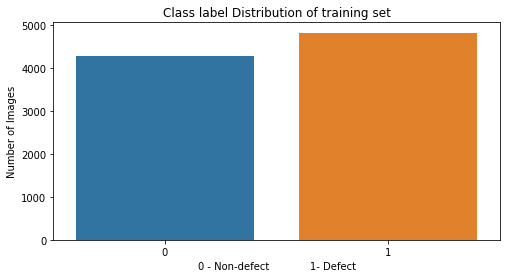

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x=X_train['defect_present'])
plt.ylabel('Number of Images')
plt.xlabel('0 - Non-defect             1- Defect')
plt.title('Class label Distribution of training set')
plt.show()

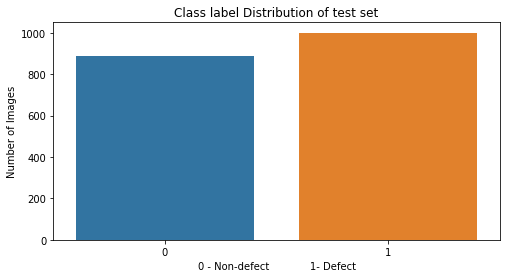

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x=X_test['defect_present'])
plt.ylabel('Number of Images')
plt.xlabel('0 - Non-defect             1- Defect')
plt.title('Class label Distribution of test set')
plt.show()

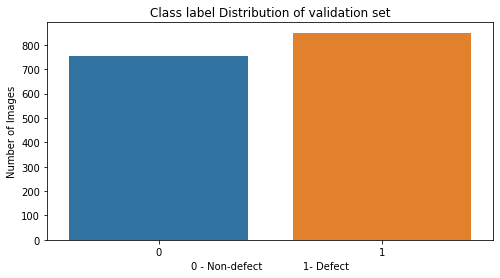

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x=X_validation['defect_present'])
plt.ylabel('Number of Images')
plt.xlabel('0 - Non-defect             1- Defect')
plt.title('Class label Distribution of validation set')
plt.show()

## Image Data Generator with Augmentation for Train, Test and Validation sets

In [ ]:
# Training data augmentaion
train_data_generator = ImageDataGenerator(
                                          rescale=1./255.,
                                          rotation_range=20,
                                          zoom_range=0.05,
                                          width_shift_range=0.05,
                                          height_shift_range=0.05,
                                          shear_range=0.05,
                                          horizontal_flip=True)

# Training data generator
train_generator = train_data_generator.flow_from_dataframe( 
                                          dataframe = X_train, 
                                          directory = TRAINING_IMAGES,
                                          x_col = "ImageId",
                                          y_col = "defect_present",
                                          batch_size = BATCH_SIZE,
                                          shuffle = True,
                                          class_mode = "other",
                                          target_size = (CLASSIFIER_MODEL_IMAGE_SIZE, CLASSIFIER_MODEL_IMAGE_SIZE)
                                          )

# Validation data augmentaion
validation_data_generator = ImageDataGenerator(
                                          rescale=1./255.,
                                          rotation_range=20,
                                          zoom_range=0.05,
                                          width_shift_range=0.05,
                                          height_shift_range=0.05,
                                          shear_range=0.05,
                                          horizontal_flip=True)
# Validation data generator
validation_generator = validation_data_generator.flow_from_dataframe(
                                          dataframe = X_validation,
                                          directory = TRAINING_IMAGES,
                                          x_col = "ImageId",
                                          y_col = "defect_present",
                                          batch_size = BATCH_SIZE,
                                          shuffle = True,
                                          class_mode = "other",
                                          target_size = (CLASSIFIER_MODEL_IMAGE_SIZE, CLASSIFIER_MODEL_IMAGE_SIZE)
                                          )

# Test data augmentaion
test_data_generator = ImageDataGenerator(
                                          rescale=1./255.,
                                          rotation_range=20,
                                          zoom_range=0.05,
                                          width_shift_range=0.05,
                                          height_shift_range=0.05,
                                          shear_range=0.05,
                                          horizontal_flip=True)
# Test data generator
test_generator = test_data_generator.flow_from_dataframe(
                                          dataframe = X_test,
                                          directory = TRAINING_IMAGES,
                                          x_col = "ImageId",
                                          y_col = None,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False,
                                          class_mode = None,
                                          target_size = (CLASSIFIER_MODEL_IMAGE_SIZE, CLASSIFIER_MODEL_IMAGE_SIZE)
                                          )

# Step sizes for model fitting
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 9079 validated image filenames.
Found 1603 validated image filenames.
Found 1886 validated image filenames.


## Model

In [ ]:
xception=Xception(input_shape=(CLASSIFIER_MODEL_IMAGE_SIZE,CLASSIFIER_MODEL_IMAGE_SIZE,3),include_top=False)

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
# Getting top classification layer for the model
model_clf = get_top_layer_classifer_model(xception)

# early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', patience=CLASSIFIER_MODEL_PATIENCE, verbose=1, mode='min')

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath= CLASSIFIER_MODEL_PATH, verbose= 1, save_best_only=True)

In [ ]:
history_clf = model_clf.fit(
                    train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    epochs=CLASSIFIER_MODEL_EPOCH,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=[checkpointer, earlystopping]
                    )

Epoch 1/40
378/378 [==============================] - 300s 774ms/step - loss: 0.5032 - accuracy: 0.7702 - val_loss: 0.7003 - val_accuracy: 0.5562

Epoch 00001: val_loss improved from inf to 0.70025, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/CLASSIFER_MODEL/classifer_model_xception.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
378/378 [==============================] - 291s 769ms/step - loss: 0.3244 - accuracy: 0.8644 - val_loss: 0.3548 - val_accuracy: 0.8573

Epoch 00002: val_loss improved from 0.70025 to 0.35484, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/CLASSIFER_MODEL/classifer_model_xception.hdf5
Epoch 3/40
378/378 [==============================] - 290s 765ms/step - loss: 0.2611 - accuracy: 0.8904 - val_loss: 0.2848 - val_accuracy: 0.8744

Epoch 00003: val_loss improved from 0.35484 to 0.28482, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/CLASSIFER_MODEL/classifer_model_xception.hdf5
Epoch 4/40
378/378 [==============================] - 290s 766ms/step - loss: 0.2289 - accuracy: 0.9090 - val_loss: 0.2384 - val_accuracy: 0.9066

Epoch 00004: val_loss improved from 0.28482 to 0.23840, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/CLASSIFER_MODEL/classifer_model_xception.hdf5
Epoch 5/40
378/3

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


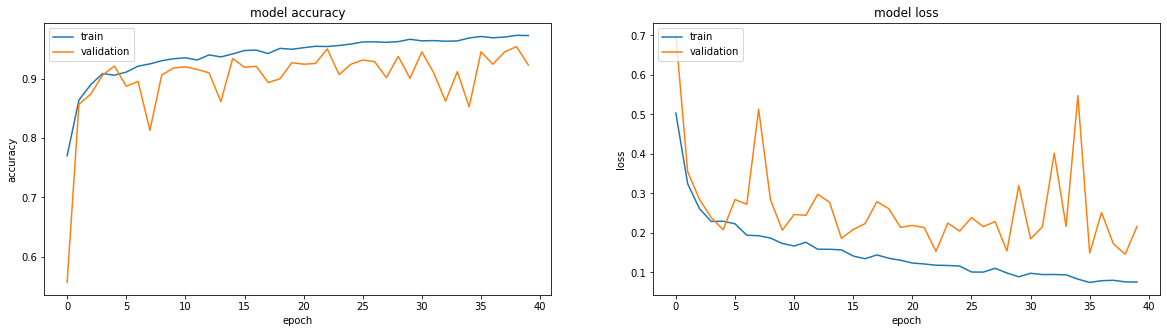

In [ ]:
get_history_plot(history_clf, 'accuracy')

## Prediction 

In [ ]:
test_predict = model_clf.predict(test_generator, steps =STEP_SIZE_TEST, verbose =1)

78/78 [==============================] - 50s 636ms/step


Threshold value :  0.1
AUC :  0.9290970933828077
------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       882
           1       0.91      0.96      0.94       990

    accuracy                           0.93      1872
   macro avg       0.93      0.93      0.93      1872
weighted avg       0.93      0.93      0.93      1872
 



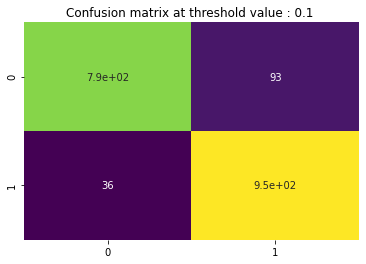

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 

Threshold value :  0.15
AUC :  0.9327458256029685
------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       882
           1       0.92      0.96      0.94       990

    accuracy                           0.93      1872
   macro avg       0.94      0.93      0.93      1872
weighted avg       0.94      0.93      0.93      1872
 



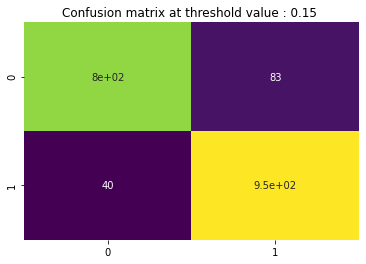

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 

Threshold value :  0.2
AUC :  0.9329931972789115
------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       882
           1       0.92      0.96      0.94       990

    accuracy                           0.93      1872
   macro avg       0.94      0.93      0.93      1872
weighted avg       0.93      0.93      0.93      1872
 



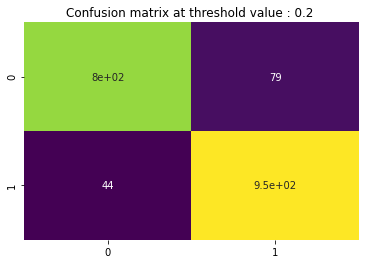

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 

Threshold value :  0.25
AUC :  0.935064935064935
------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       882
           1       0.93      0.95      0.94       990

    accuracy                           0.94      1872
   macro avg       0.94      0.94      0.94      1872
weighted avg       0.94      0.94      0.94      1872
 



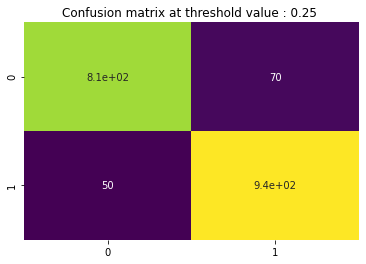

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 

Threshold value :  0.3
AUC :  0.9381467738610595
------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       882
           1       0.94      0.95      0.94       990

    accuracy                           0.94      1872
   macro avg       0.94      0.94      0.94      1872
weighted avg       0.94      0.94      0.94      1872
 



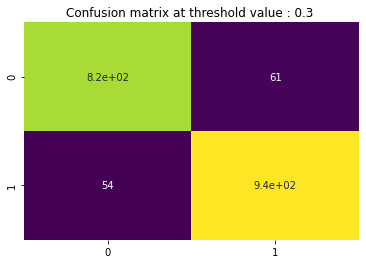

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 

Threshold value :  0.35
AUC :  0.9349824778396207
------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       882
           1       0.94      0.93      0.94       990

    accuracy                           0.93      1872
   macro avg       0.93      0.93      0.93      1872
weighted avg       0.93      0.93      0.93      1872
 



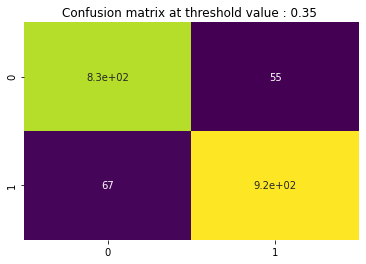

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 

Threshold value :  0.4
AUC :  0.9376211090496805
------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       882
           1       0.95      0.93      0.94       990

    accuracy                           0.94      1872
   macro avg       0.94      0.94      0.94      1872
weighted avg       0.94      0.94      0.94      1872
 



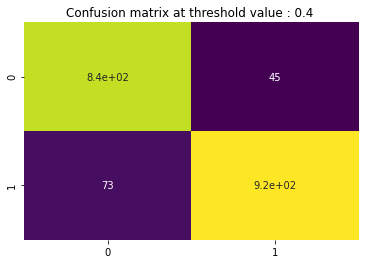

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 

Threshold value :  0.45
AUC :  0.9374252731395589
------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       882
           1       0.96      0.92      0.94       990

    accuracy                           0.94      1872
   macro avg       0.94      0.94      0.94      1872
weighted avg       0.94      0.94      0.94      1872
 



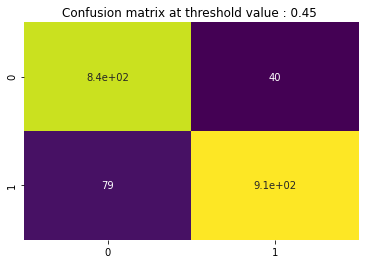

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 

Threshold value :  0.5
AUC :  0.9350855493712636
------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       882
           1       0.96      0.91      0.94       990

    accuracy                           0.93      1872
   macro avg       0.93      0.94      0.93      1872
weighted avg       0.94      0.93      0.93      1872
 



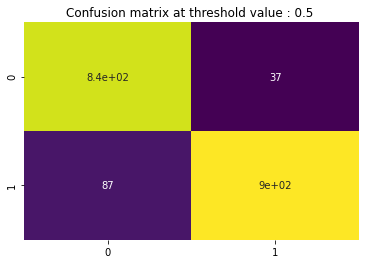

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 



In [ ]:
f1_score_list = []
threshold = [0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5]
for t in threshold:
  predict = []
  for pred in test_predict:
    if pred < t:
      predict.append(0)
    else:
      predict.append(1)
  predict = np.asarray(predict)
  original = np.asarray(X_test.defect_present)[:len(predict)]
  f1_score_list.append(f1_score(original, predict))
  print('Threshold value : ',t)
  fpr, tpr, test_thresholds = roc_curve(original, predict)
  print('AUC : ',auc(fpr, tpr))
  print('-'*55,'\n')
  f1_score_list.append(f1_score(original, predict))
  print(classification_report(original, predict),'\n' )
  plt.title('Confusion matrix at threshold value : %s '%t)
  sns.heatmap(confusion_matrix(original, predict), annot=True, cbar=False, cmap='viridis')
  plt.show()
  print('>'*55,'\n')
max_f1_score = f1_score_list.index(max(f1_score_list))
# print('Best F1 Score : ', f1_score_list[max_f1_score],'at Threshold value : ', threshold[max_f1_score])

## Load Classification Model

In [ ]:
model_clf = load_model(CLASSIFIER_MODEL_PATH, is_custom = False)

# Segmentation of Images using ResUNet

## Splitting data into Train, Test and Validation sets

In [ ]:
X_train_seg, X_test_seg = train_test_split(DF_TRAIN, test_size=0.15,stratify = DF_TRAIN['ClassId'], random_state=0)
X_train_seg, X_validation_seg = train_test_split(X_train_seg, test_size=0.15,stratify = X_train_seg['ClassId'], random_state=0)
print('Number of images in Training set : ',X_train_seg.shape[0])
print('Number of images in Test set : ', X_test_seg.shape[0])
print('Number of images in Validation set : ', X_validation_seg.shape[0]) 

Number of images in Training set :  5125
Number of images in Test set :  1065
Number of images in Validation set :  905


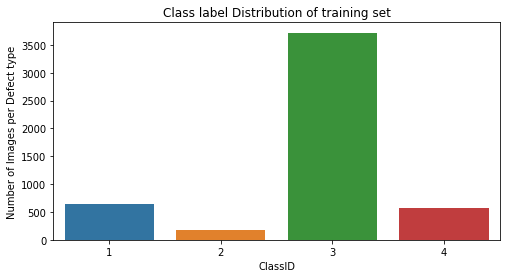

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x = X_train_seg['ClassId'])
plt.xlabel('ClassID')
plt.ylabel('Number of Images per Defect type')
plt.title('Class label Distribution of training set')
plt.show()

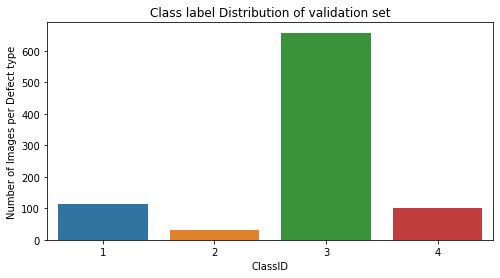

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x = X_validation_seg['ClassId'])
plt.xlabel('ClassID')
plt.ylabel('Number of Images per Defect type')
plt.title('Class label Distribution of validation set')
plt.show()

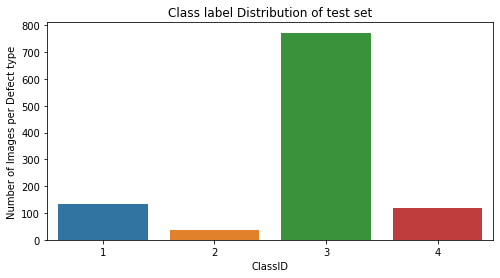

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x = X_test_seg['ClassId'])
plt.xlabel('ClassID')
plt.ylabel('Number of Images per Defect type')
plt.title('Class label Distribution of test set')
plt.show()

## Image Data Generator Train, Validation sets

In [ ]:
train_ids = list(X_train_seg.ImageId)
train_class = list(X_train_seg.ClassId)
train_rle = list(X_train_seg.EncodedPixels)

val_ids = list(X_validation_seg.ImageId)
val_class = list(X_validation_seg.ClassId)
val_rle = list(X_validation_seg.EncodedPixels)

In [ ]:
training_generator_seg = DataGenerator(train_ids,train_class, train_rle, TRAINING_IMAGES)
validation_generator_seg = DataGenerator(val_ids,val_class,val_rle, TRAINING_IMAGES)

## Model

### ResUNet Architecture

In [ ]:
def resblock(X, f):
  # making a copy of input
  X_copy = X

  # main path
  X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

# function to upscale and concatnating the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

input_shape = (SEGMENTATION_MODEL_IMAGE_SIZE,SEGMENTATION_MODEL_IMAGE_SIZE,1)

#Input tensor shape
X_input = Input(input_shape)

#Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

#Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

#Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

#Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

#Stage 5
conv5_in = resblock(pool_4, 256)

#Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

#Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

#Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

#Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

#Final Output
output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output)
model_seg.compile(optimizer = 'adam', loss = dice_loss, metrics = [dice_coef])

### Training

In [ ]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping_seg = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=SEGMENTATION_MODEL_PATIENCE)

# save the best model with lower validation loss
checkpointer_seg = ModelCheckpoint(filepath= SEGMENTATION_MODEL_PATH, verbose=1, save_best_only=True)

In [ ]:
history_seg = model_seg.fit(training_generator_seg,
                                     epochs = SEGMENTATION_MODEL_EPOCH,
                                     validation_data= validation_generator_seg,
                                     callbacks=[checkpointer_seg, earlystopping_seg]
                            )

Epoch 1/20
320/320 [==============================] - 90s 272ms/step - loss: 0.7514 - dice_coef: 0.2486 - val_loss: 0.6852 - val_dice_coef: 0.3148

Epoch 00001: val_loss improved from inf to 0.68522, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/SEGMENTATION_MODEL/segmentation_model_resunet_2.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
320/320 [==============================] - 87s 270ms/step - loss: 0.5575 - dice_coef: 0.4425 - val_loss: 0.5764 - val_dice_coef: 0.4236

Epoch 00002: val_loss improved from 0.68522 to 0.57638, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/SEGMENTATION_MODEL/segmentation_model_resunet_2.hdf5
Epoch 3/20
320/320 [==============================] - 87s 270ms/step - loss: 0.5210 - dice_coef: 0.4790 - val_loss: 0.6172 - val_dice_coef: 0.3828

Epoch 00003: val_loss did not improve from 0.57638
Epoch 4/20
320/320 [==============================] - 86s 269ms/step - loss: 0.4929 - dice_coef: 0.5071 - val_loss: 0.4873 - val_dice_coef: 0.5127

Epoch 00004: val_loss improved from 0.57638 to 0.48734, saving model to /content/drive/MyDrive/Steel Defect Detection and Localization/SEGMENTATION_MODEL/segmentation_model_resunet_2.hdf5
Epoch 5/20
320/320 [==============================] - 86s 268ms/step - loss: 0.4738 - dice_coef: 0.5262 - val_loss: 0.4712 - val_

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef'])


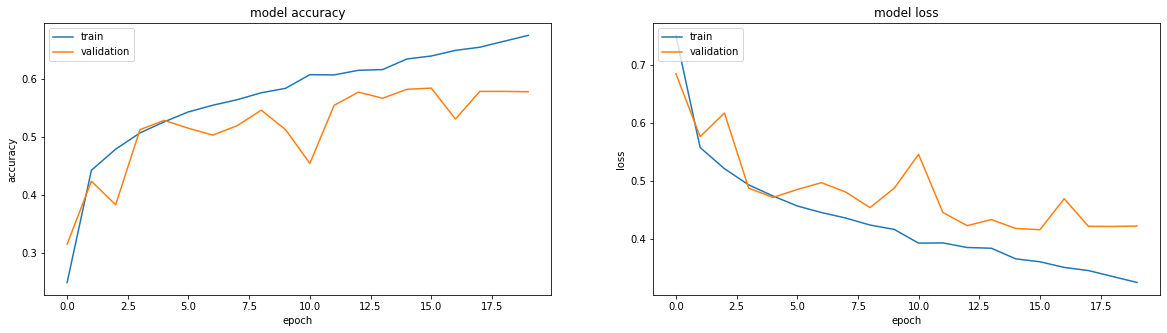

In [ ]:
get_history_plot(history_seg, metric_string= 'dice_coef')

## Prediction 

In [ ]:
def predict_mask(df, model_seg, image_path):

  #Creating empty list to store the results
  mask = []
  defect_type = []
  image_id = []
  
  #iterating through each image datafra
  for i in df.ImageId:
    path = os.path.join(image_path, i)

    #reading the image
    img = io.imread(path)       
    
    #reading the image along blue channel (0)
    img =img[:,:,0]

    #Creating a empty array of shape 1,256,256,1
    X = np.empty((1, 256, 256, 1))

    #resizing the image and coverting them to array of type float64
    img = cv2.resize(img,(256,256))
    img = np.array(img, dtype = np.float64)

    #standardising the image
    img -= img.mean()
    img /= img.std()

    #converting the shape of image from 256,256 to 1,256,256,1
    X[0,] = np.expand_dims(img, axis = 2)

    #make prediction
    predict = model_seg.predict(X)

    #if the sum of predicted values is equal to 0 then there is no defect
    if predict.round().astype(int).sum() == 0:
      image_id.append(i)
      defect_type.append(0)
      mask.append('0 0')
      continue

    #iterating 4 times to get the prediction of 4 different classes
    for j in range(4):
      #since j values through iteration are 0,1,2,3 , we add 1 to j to make it as classIDs corresponding to 1,2,3,4
      class_id = j + 1

      #get the mask values of each class
      mask_value = predict[0,:,:,j].round().astype(int)

      #if the sum of mask values is greater than 0.5(anything greater than 0 ), that class has defect
      if mask_value.sum() > 0.5:
        try:
            #applying mask to image, area with defect will be highlighted in white(255)
            img[mask_value == 1] = 255
            #since our original shape is 256,1600, reshape to that size
            img = cv2.resize(img,(1600,256))
            #Now, mask the image such that, areas which are not white(defected areas) to be black(0)
            img[img < 255] = 0
            #again normalize the values
            img = img * 1./255.
            #get the rle for the create masked image
            rle = mask2rle(img)
        except:
            continue

        #append the valeues to the respective listes
        image_id.append(i)
        defect_type.append(class_id)
        mask.append(rle)

  return image_id, defect_type, mask

In [ ]:
image_id, defect_type, mask = predict_mask(X_test_seg, model_seg, TRAINING_IMAGES)
df_pred = pd.DataFrame({'ImageId': image_id,'ClassId': defect_type, 'EncodedPixels': mask})

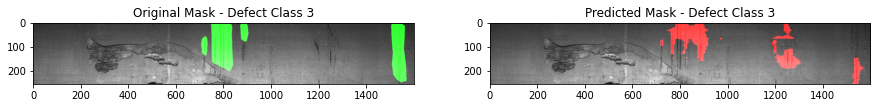

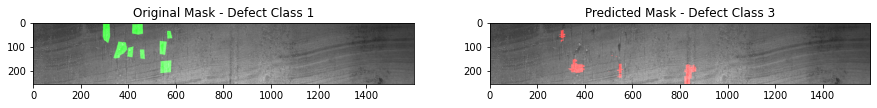

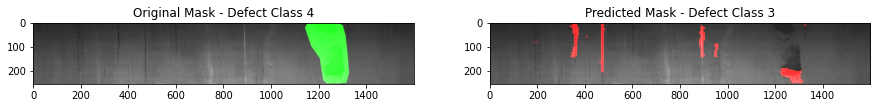

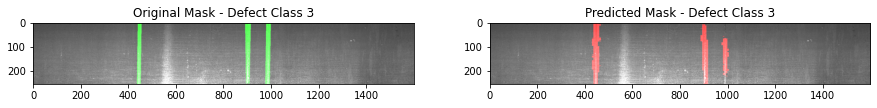

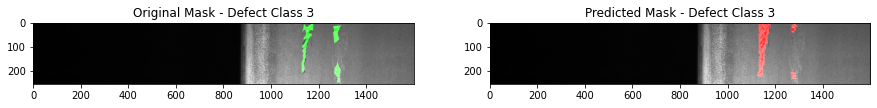

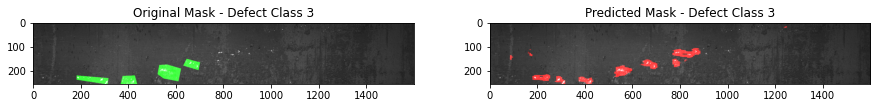

In [ ]:
show_original_pred_mask(TRAINING_IMAGES, X_test_seg, df_pred, 5)

# Final Prediction

In [ ]:
# Get prediction
image_id, dt, mask = prediction(X_test_seg, model_clf, model_seg, image_path=TRAINING_IMAGES)

# create a dataframe for the result
df_pred= pd.DataFrame({'ImageId': image_id,'EncodedPixels': mask,'ClassId': dt})
df_pred.head()

100%|██████████| 1065/1065 [02:02<00:00,  8.71it/s]


,ImageId,EncodedPixels,ClassId
0,ada844648.jpg,183367 26 183623 26 183879 26 184135 26 184391...,3
1,81aed13bf.jpg,74543 2 74551 3 74799 2 74807 3 75055 2 75063 ...,3
2,843b29efa.jpg,47183 2 47439 2 47695 2 47951 2 48207 2 48463 ...,3
3,4d7acd005.jpg,109629 1 109633 31 109679 1 109699 2 109705 8 ...,3
4,fb38bb7bf.jpg,287279 2 287437 18 287535 2 287693 18 287791 2...,3


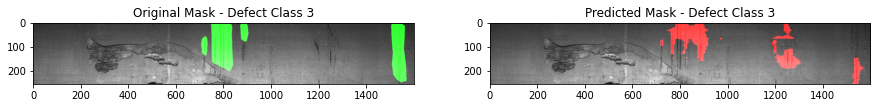

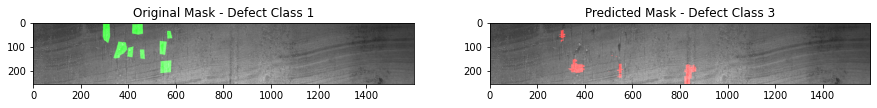

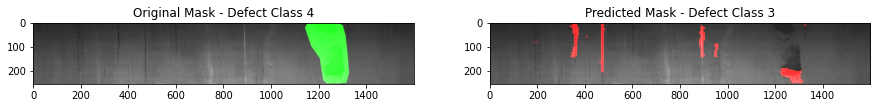

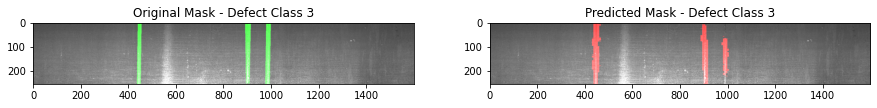

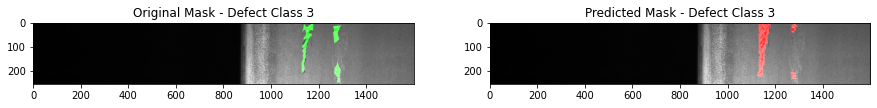

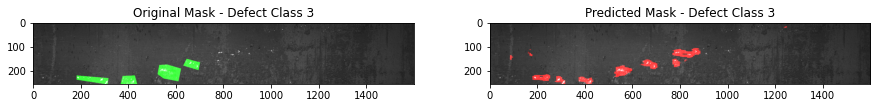

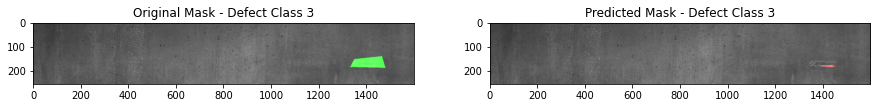

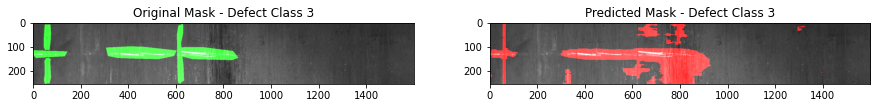

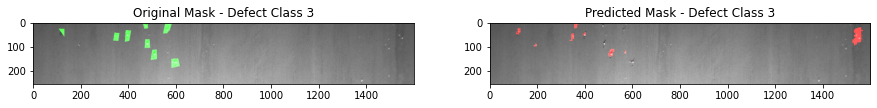

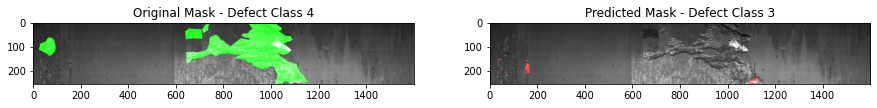

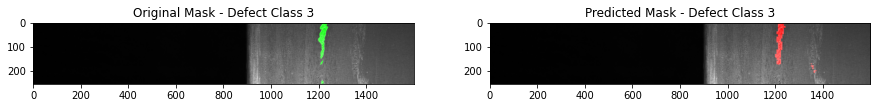

In [ ]:
show_original_pred_mask(TRAINING_IMAGES, X_test_seg, df_pred, 10)

**Observation :**

* The model is doing a good job on Defect class 3. 

* Rest of the Defect Classes are barely getting detected. This is due to the imbalance in the dataset and also because of the small area for Defect 1 and 2.

* ***Scope of improvement :*** Repeat the augmented samples of the minority classes like
Defect Class 1,2 and 4